## Forcing Evaluation ##



### Write snakemake file ###

This block of code writes the snakemake file

In [2]:
import os, sys
from pathlib import Path
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import yaml

1


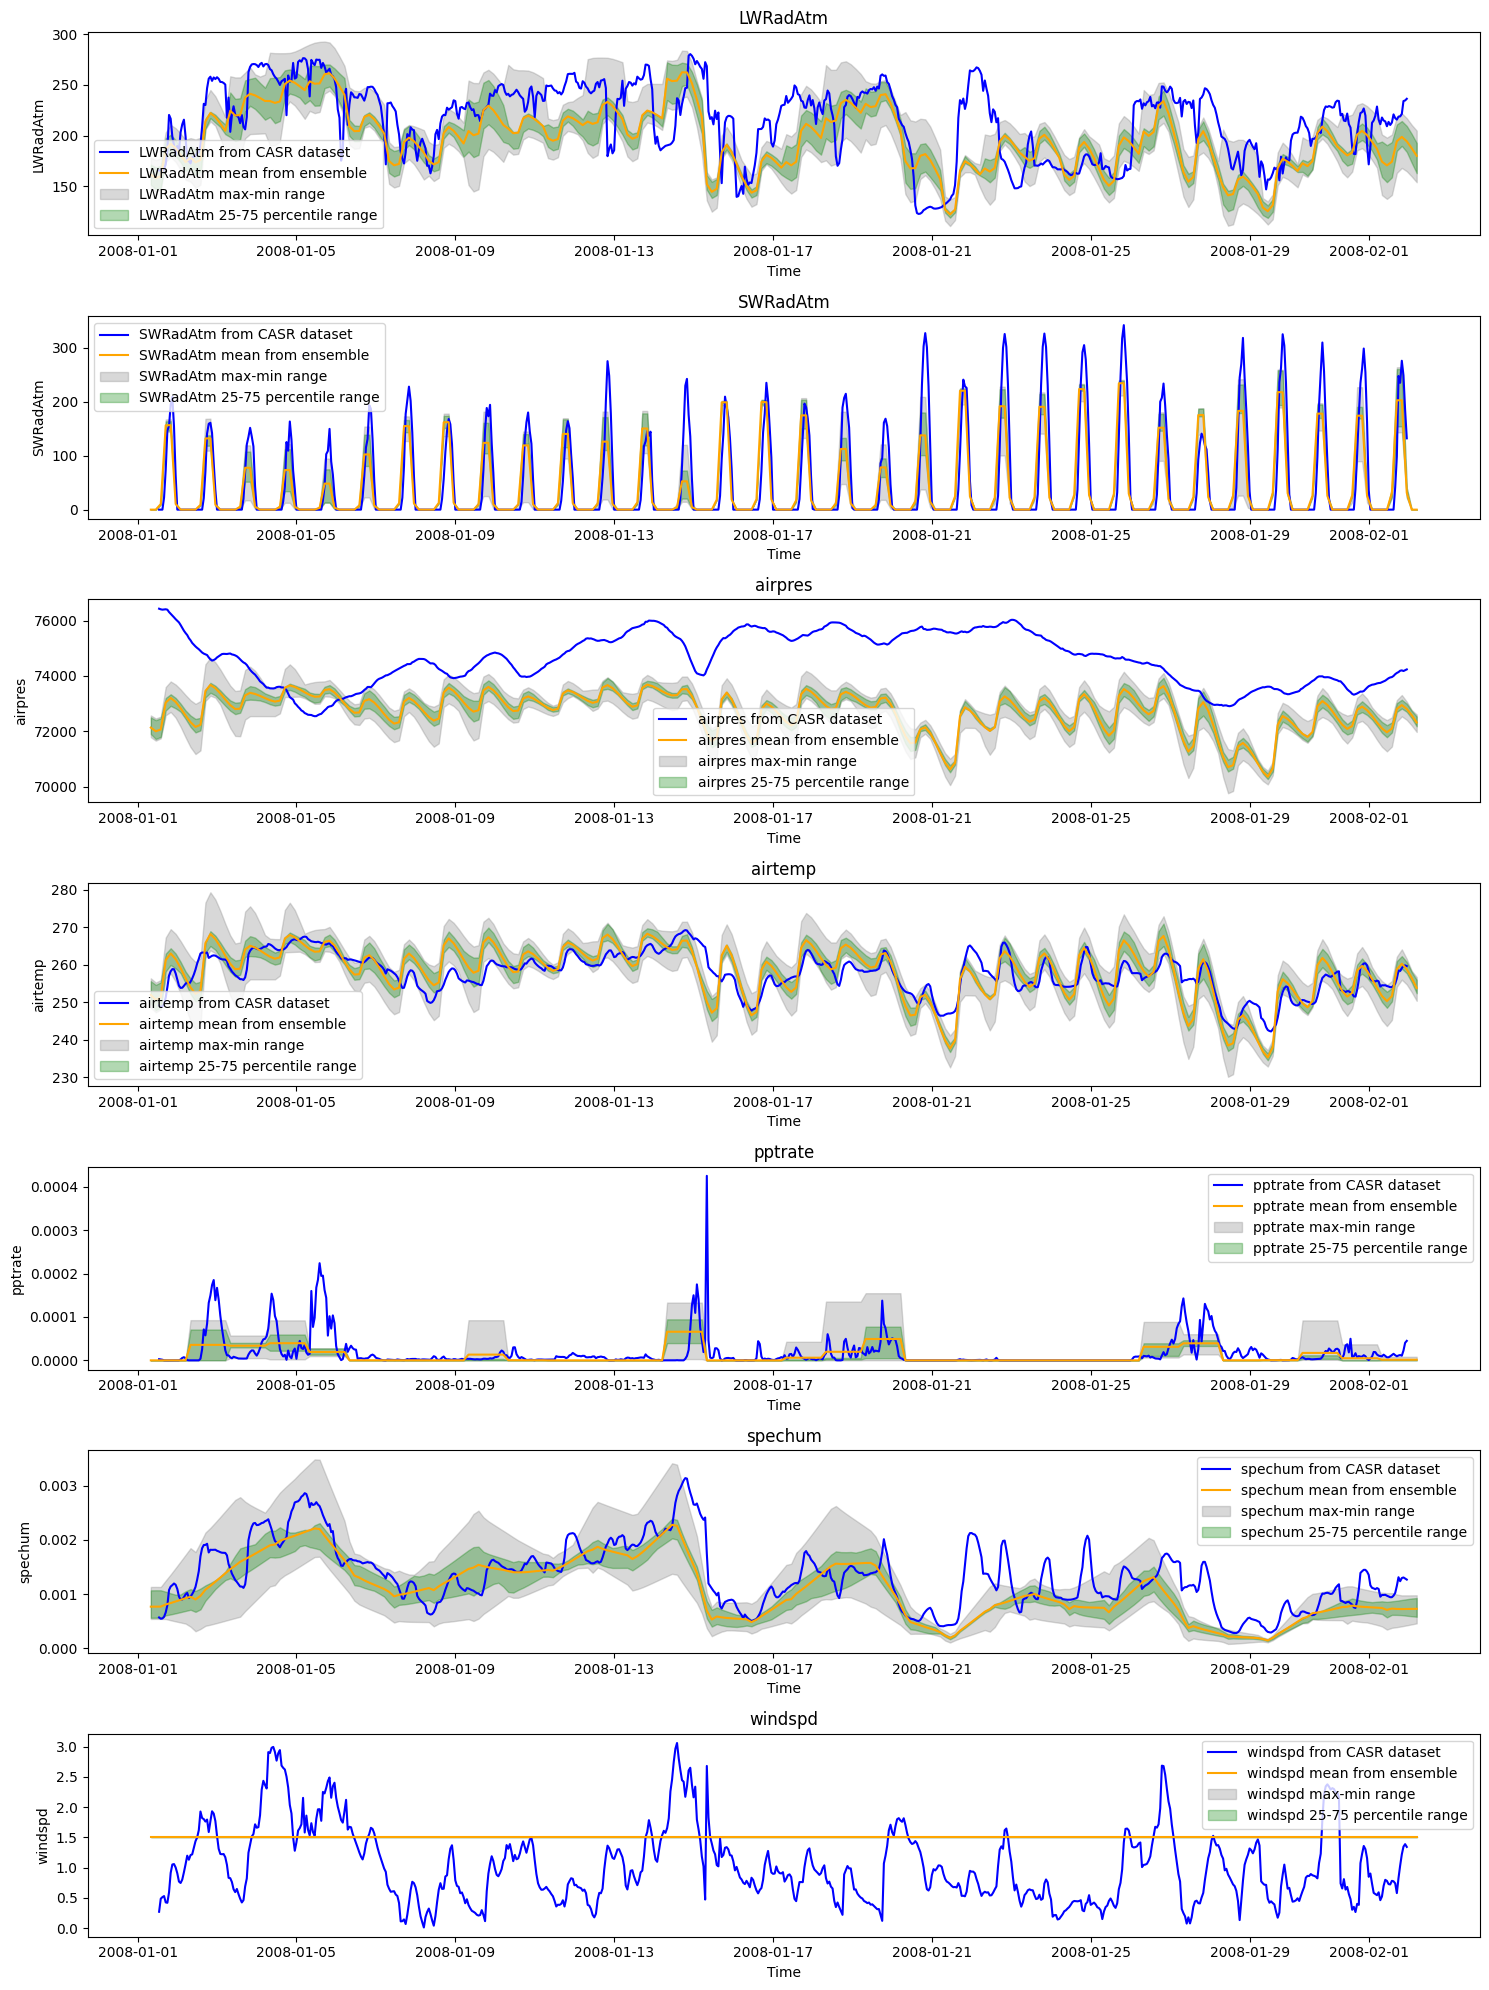

In [11]:
def plot_forcing_variables(casr_dataset, ens_data_path, hru_id, start_time=None, end_time=None, shift_hours=8):
    """
    Plots the seven forcing variables for a given station (hru_id) and time period across multiple datasets.

    Parameters:
    casr_dataset (xarray.Dataset): The CASR dataset loaded from the NetCDF files.
    ens_data_path (str): The path to the ensemble datasets directory.
    hru_id (int): The station identifier.
    start_time (str, optional): The start of the time period (inclusive).
    end_time (str, optional): The end of the time period (inclusive).
    shift_hours (int, optional): The number of hours to shift the ensemble data forward. Default is 8.
    """

    # Load ensemble datasets separately
    ens_files = Path(ens_data_path).glob('*.nc')
    ens_datasets = [xr.open_dataset(file) for file in ens_files]

    # Collect all variables from the CASR dataset
    all_variables = set(var for var in casr_dataset.data_vars if var not in ['hruId', 'data_step', 'time', 'latitude', 'longitude'])

    # Plotting each variable across the CASR dataset and ensemble statistics
    plt.figure(figsize=(15, 20))
    for i, var in enumerate(sorted(all_variables), 1):
        plt.subplot(len(all_variables), 1, i)

        # Filter the CASR data for the given hru_id and time period
        if start_time and end_time:
            casr_filtered = casr_dataset.sel(hru=hru_id, time=slice(start_time, end_time))
        else:
            casr_filtered = casr_dataset.sel(hru=hru_id)

        if var in casr_dataset.data_vars:
            plt.plot(casr_filtered['time'], casr_filtered[var], label=f"{var} from CASR dataset", color='blue')

        # Filter the ensemble data for the given hru_id and time period
        ens_filtered_list = []
        for ens_dataset in ens_datasets:
            if start_time and end_time:
                ens_filtered = ens_dataset.sel(hru=hru_id, time=slice(start_time, end_time))
            else:
                ens_filtered = ens_dataset.sel(hru=hru_id)
            
            # Shift the time forward by the specified number of hours
            ens_filtered['time'] = ens_filtered['time'] + np.timedelta64(shift_hours, 'h')
            ens_filtered_list.append(ens_filtered)

        if ens_filtered_list:
            # Concatenate along a new dimension 'ensemble'
            ens_combined = xr.concat(ens_filtered_list, dim='ensemble')

            if var in ens_combined.data_vars:
                # Calculate statistics
                ens_mean = ens_combined[var].mean(dim='ensemble')
                ens_min = ens_combined[var].min(dim='ensemble')
                ens_max = ens_combined[var].max(dim='ensemble')
                ens_25 = ens_combined[var].quantile(0.25, dim='ensemble')
                ens_75 = ens_combined[var].quantile(0.75, dim='ensemble')

                # Plot statistics
                plt.plot(ens_combined['time'], ens_mean, label=f"{var} mean from ensemble", color='orange')
                plt.fill_between(ens_combined['time'], ens_min, ens_max, color='gray', alpha=0.3, label=f"{var} max-min range")
                plt.fill_between(ens_combined['time'], ens_25, ens_75, color='green', alpha=0.3, label=f"{var} 25-75 percentile range")

        plt.title(var)
        plt.xlabel('Time')
        plt.ylabel(var)
        plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage of the function with sample hru_id and time period
casr_data_path = '/Users/dcasson/Data/snow_analysis/bow/casr_forcing'
casr_dataset = xr.open_mfdataset(casr_data_path + '/*.nc', combine='nested', concat_dim='time')
ens_data_path = '/Users/dcasson/Data/snow_analysis/bow/gpep_forcing'
sample_hru_id = casr_dataset['hru'][1].values  # Using the first hruId for demonstration
start_time = '2008-01-01'
end_time = '2008-02-01'
print(sample_hru_id)

plot_forcing_variables(casr_dataset, ens_data_path, sample_hru_id, start_time, end_time)

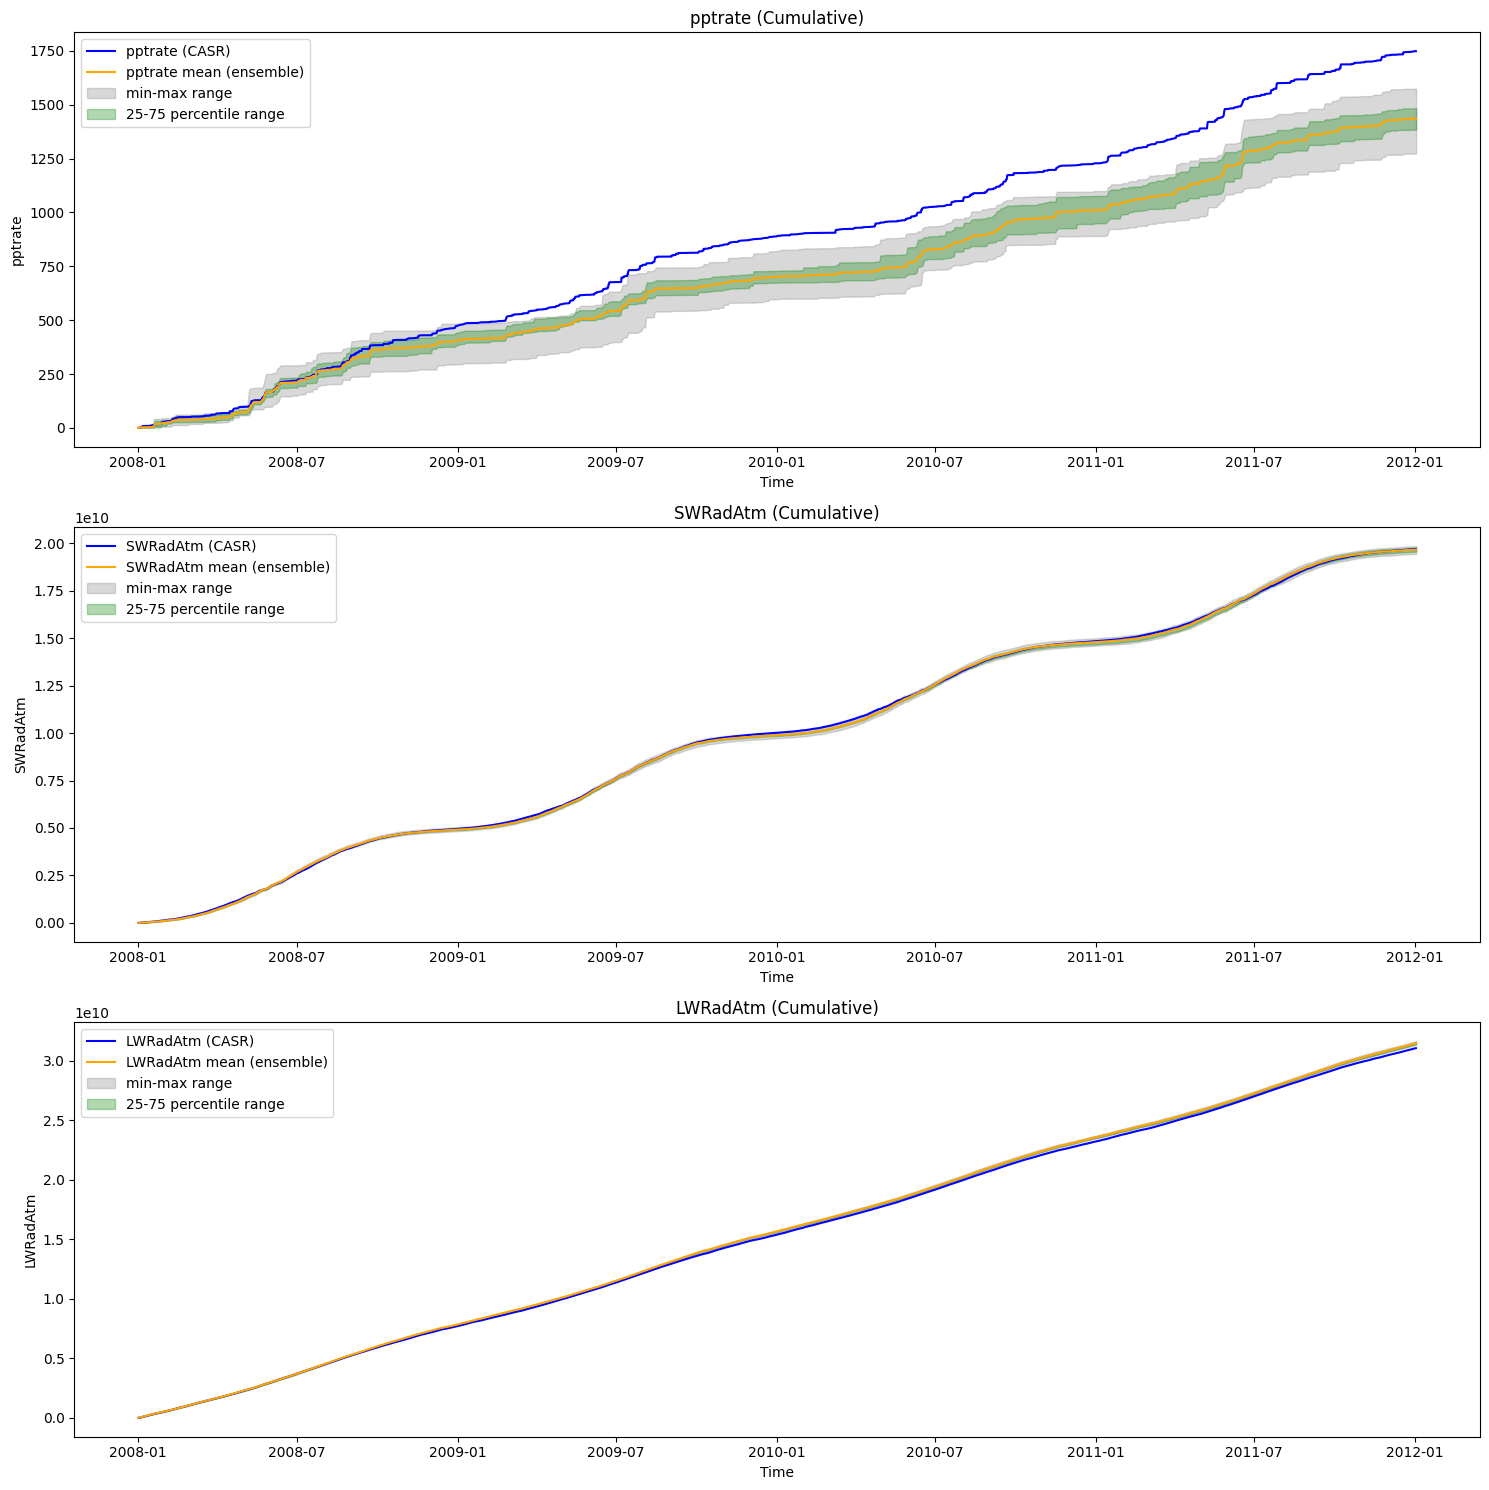

In [18]:
def plot_cumulative_forcing_variables(
    casr_dataset,
    ens_data_path,
    hru_id,
    cumulative_vars=None,
    start_time=None,
    end_time=None,
    shift_hours=8,
    casr_datastep=3600,
    ens_datastep=10800
):
    """
    Plots selected variables (optionally as cumulative sum, accounting for timestep) for a given HRU and time period.
    """

    from pathlib import Path
    import matplotlib.pyplot as plt
    import numpy as np
    import xarray as xr

    if cumulative_vars is None:
        cumulative_vars = []

    # Load ensemble datasets
    ens_files = list(Path(ens_data_path).glob('*.nc'))
    ens_datasets = [xr.open_dataset(file) for file in ens_files]

    # Which variables to plot: only cumulative_vars if specified, else all except meta variables
    if cumulative_vars:
        variables_to_plot = cumulative_vars
    else:
        variables_to_plot = [v for v in casr_dataset.data_vars if v not in ['hruId', 'data_step', 'time', 'latitude', 'longitude']]

    plt.figure(figsize=(15, 5 * len(variables_to_plot)))
    for i, var in enumerate(variables_to_plot, 1):
        plt.subplot(len(variables_to_plot), 1, i)

        # Filter for HRU and time
        casr_filtered = casr_dataset.sel(hru=hru_id)
        if start_time and end_time:
            casr_filtered = casr_filtered.sel(time=slice(start_time, end_time))

        if var in casr_filtered.data_vars:
            plot_data = casr_filtered[var]
            # Cumulative sum with dt
            if var in cumulative_vars:
                plot_data = (plot_data * casr_datastep).cumsum(dim='time')
            plt.plot(casr_filtered['time'], plot_data, label=f"{var} (CASR)", color='blue')

        # Ensemble datasets: process all
        ens_filtered_list = []
        for ens_dataset in ens_datasets:
            try:
                ens_sel = ens_dataset.sel(hru=hru_id)
                if start_time and end_time:
                    ens_sel = ens_sel.sel(time=slice(start_time, end_time))
                # Shift time
                ens_sel = ens_sel.assign_coords(time=ens_sel['time'] + np.timedelta64(shift_hours, 'h'))
                ens_filtered_list.append(ens_sel)
            except Exception as e:
                print(f"Skipping ensemble due to: {e}")

        if ens_filtered_list and var in ens_filtered_list[0].data_vars:
            ens_combined = xr.concat(ens_filtered_list, dim='ensemble')
            plot_data_ens = ens_combined[var]
            # Cumulative sum with dt
            if var in cumulative_vars:
                plot_data_ens = (plot_data_ens * ens_datastep).cumsum(dim='time')
            ens_mean = plot_data_ens.mean(dim='ensemble')
            ens_min = plot_data_ens.min(dim='ensemble')
            ens_max = plot_data_ens.max(dim='ensemble')
            ens_25 = plot_data_ens.quantile(0.25, dim='ensemble')
            ens_75 = plot_data_ens.quantile(0.75, dim='ensemble')

            plt.plot(ens_combined['time'], ens_mean, label=f"{var} mean (ensemble)", color='orange')
            plt.fill_between(ens_combined['time'], ens_min, ens_max, color='gray', alpha=0.3, label="min-max range")
            plt.fill_between(ens_combined['time'], ens_25, ens_75, color='green', alpha=0.3, label="25-75 percentile range")

        plt.title(f"{var} {'(Cumulative)' if var in cumulative_vars else ''}")
        plt.xlabel('Time')
        plt.ylabel(var)
        plt.legend()

    plt.tight_layout()
    plt.show()

cumulative_vars = ['pptrate', 'SWRadAtm', 'LWRadAtm']
casr_datastep = 3600   # seconds
ens_datastep = 10800   # seconds
sample_hru_id = 200
plot_cumulative_forcing_variables(
    casr_dataset,
    ens_data_path,
    sample_hru_id,
    cumulative_vars=cumulative_vars,
    start_time=start_time,
    end_time=end_time,
    casr_datastep=casr_datastep,
    ens_datastep=ens_datastep
)

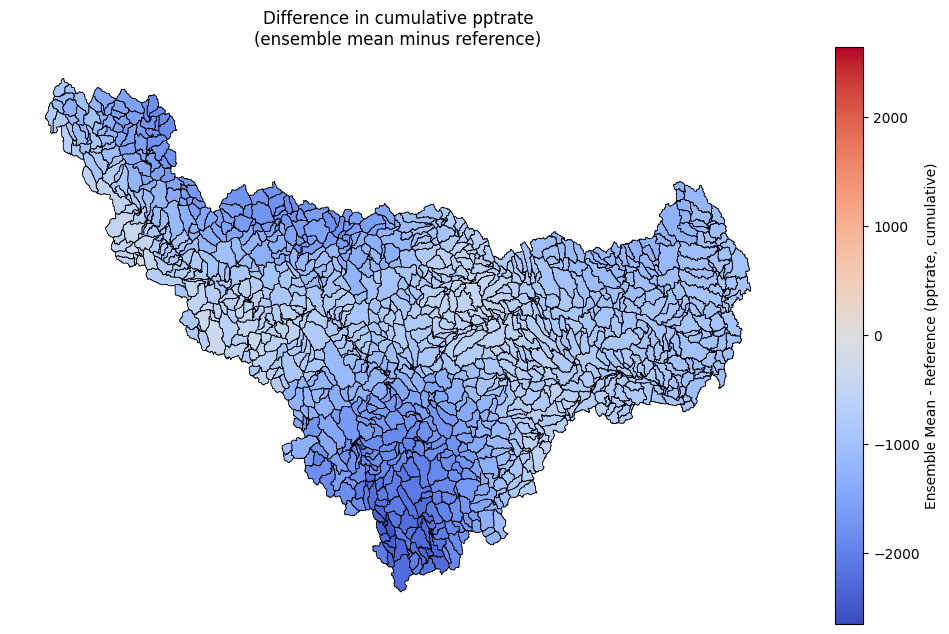

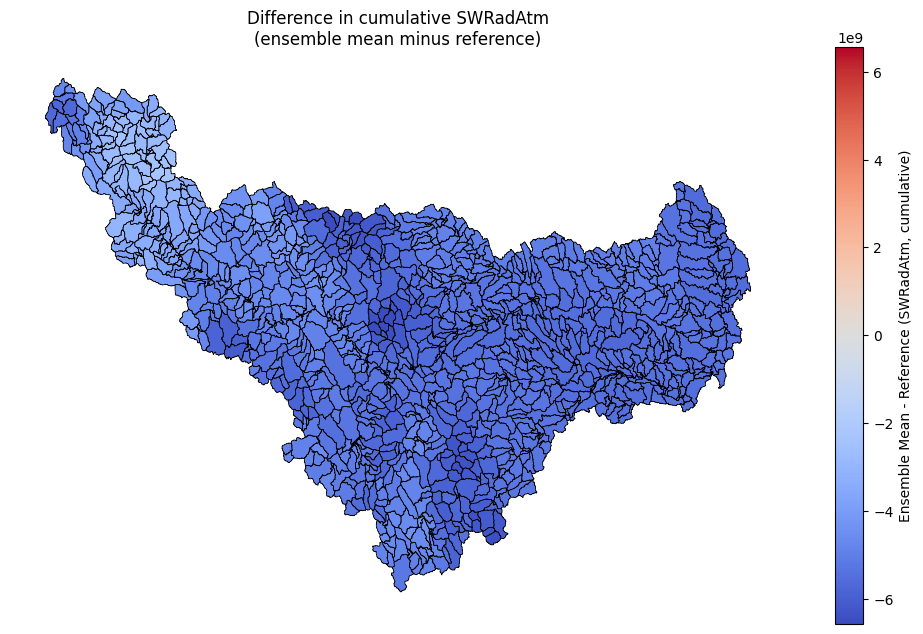

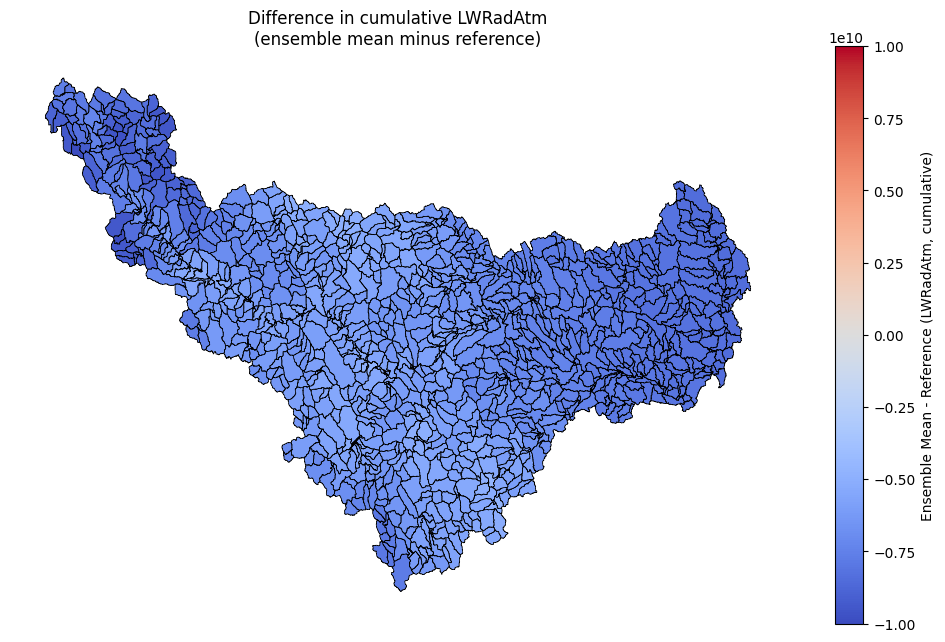

In [21]:
import geopandas as gpd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def plot_spatial_cumulative_difference(
    casr_dataset,                # Reference NetCDF Dataset (e.g., CASR)
    ens_data_path,               # Path to ensemble NetCDF files (directory)
    gpkg_path,                   # Path to GPKG file with HRU polygons
    cumulative_vars,             # List of cumulative variable names (e.g. ['pptrate', 'SWRadAtm'])
    casr_datastep=3600,          # Seconds per timestep in CASR
    ens_datastep=10800,          # Seconds per timestep in ensemble
    start_time=None,             # Start time (string or np.datetime64)
    end_time=None,               # End time (string or np.datetime64)
    gpkg_layer=None,             # Optionally specify GPKG layer name
    gpkg_id_field="HRU_ID",      # Field in GPKG corresponding to hruId
    netcdf_id_field="hruId"      # Field in NetCDF corresponding to HRU ID
):
    """
    Plots the spatial difference in cumulative variables between ensemble mean and reference for each HRU.
    """

    # 1. Load polygons
    gdf = gpd.read_file(gpkg_path, layer=gpkg_layer) if gpkg_layer else gpd.read_file(gpkg_path)

    # 2. Restrict to variables of interest (and available in the data)
    available_vars = [v for v in cumulative_vars if v in casr_dataset.data_vars]
    if len(available_vars) < len(cumulative_vars):
        print(f"Warning: Not all requested variables found in reference dataset: {set(cumulative_vars)-set(available_vars)}")
    if not available_vars:
        print("No requested variables found in reference dataset.")
        return

    # 3. Open ensemble datasets
    ens_files = sorted(Path(ens_data_path).glob("*.nc"))
    ens_datasets = [xr.open_dataset(f) for f in ens_files]
    # Use all available hruId values
    hru_ids = casr_dataset[netcdf_id_field].values

    # 4. Compute spatial results for each variable
    for var in available_vars:
        # 4a. Reference: sum over time (using timestep)
        casr_sel = casr_dataset
        if start_time and end_time:
            casr_sel = casr_sel.sel(time=slice(start_time, end_time))
        arr_ref = (casr_sel[var] * casr_datastep).sum(dim="time")
        # arr_ref: shape (hru,)

        # 4b. Ensemble: mean of cumulative sum over members
        ens_member_totals = []
        for ds in ens_datasets:
            ds_sel = ds
            if start_time and end_time:
                ds_sel = ds_sel.sel(time=slice(start_time, end_time))
            if var not in ds_sel.data_vars:
                continue
            member_total = (ds_sel[var] * ens_datastep).sum(dim="time")
            ens_member_totals.append(member_total)
        if not ens_member_totals:
            print(f"No ensemble members had variable {var}")
            continue
        # Stack along 'ensemble'
        arr_ens = xr.concat(ens_member_totals, dim="ensemble")
        ens_mean = arr_ens.mean(dim="ensemble")

        # 4c. Calculate difference: ensemble mean - reference (aligning by hruId)
        # Both ens_mean and arr_ref should have the same hru axis/order
        # Get HRU IDs as int for merging
        ref_hru_ids = casr_dataset[netcdf_id_field].values
        # Prepare DataFrame for merging
        diff_df = (
            {
                netcdf_id_field: ref_hru_ids,
                "diff": ens_mean.values - arr_ref.values,
                "ref": arr_ref.values,
                "ens_mean": ens_mean.values,
            }
        )
        import pandas as pd
        diff_df = pd.DataFrame(diff_df)

        # 4d. Merge with polygons by HRU_ID
        # - Ensure both are int/str as needed
        gdf[gpkg_id_field] = gdf[gpkg_id_field].astype(diff_df[netcdf_id_field].dtype)
        plot_gdf = gdf.merge(diff_df, left_on=gpkg_id_field, right_on=netcdf_id_field, how="left")

        # 5. Plot
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        vabs = np.nanmax(np.abs(plot_gdf["diff"].values))
        # Center color scale at zero
        plot_gdf.plot(
            column="diff",
            cmap="coolwarm",
            legend=True,
            vmin=-vabs,
            vmax=+vabs,
            legend_kwds={"label": f"Ensemble Mean - Reference ({var}, cumulative)", "shrink": 0.75},
            ax=ax,
            edgecolor="black",
            linewidth=0.5
        )
        ax.set_title(f"Difference in cumulative {var}\n(ensemble mean minus reference)")
        ax.axis("off")
        plt.tight_layout()
        plt.show()

gpkg_path = '/Users/dcasson/Data/summa_snakemake/bow_tdx/watershed_tools/final/bow_tdx.gpkg'
# Example usage:
plot_spatial_cumulative_difference(
    casr_dataset,
    ens_data_path,
    gpkg_path,
    cumulative_vars=['scalarSWE', 'SWRadAtm', 'LWRadAtm'],
    casr_datastep=3600,
    ens_datastep=10800,
    start_time="2008-01-01",
    end_time="2013-12-01"
)

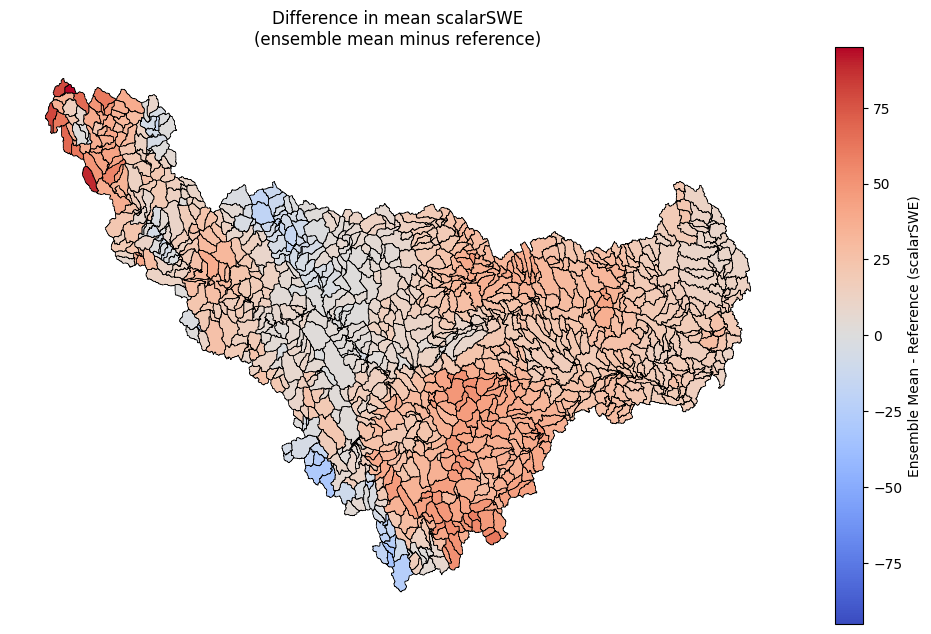

In [25]:
import geopandas as gpd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

def plot_spatial_difference(
    casr_dataset,
    ens_data_path,
    gpkg_path,
    cumulative_vars=None,       # List of cumulative variable names (e.g. ['pptrate', 'SWRadAtm'])
    mean_vars=None,             # List of variables for mean-over-time (e.g. ['scalarSWE'])
    casr_datastep=3600,
    ens_datastep=10800,
    start_time=None,
    end_time=None,
    gpkg_layer=None,
    gpkg_id_field="HRU_ID",
    netcdf_id_field="hruId"
):
    """
    Plots the spatial difference between ensemble mean and reference for each HRU.
    Cumulative variables use the sum over time * datastep;
    mean_vars use the average over time.
    """

    cumulative_vars = cumulative_vars or []
    mean_vars = mean_vars or []

    gdf = gpd.read_file(gpkg_path, layer=gpkg_layer) if gpkg_layer else gpd.read_file(gpkg_path)
    variables_to_plot = [v for v in (cumulative_vars + mean_vars) if v in casr_dataset.data_vars]

    if not variables_to_plot:
        print("No requested variables found in reference dataset.")
        return

    ens_files = sorted(Path(ens_data_path).glob("*.nc"))
    ens_datasets = [xr.open_dataset(f) for f in ens_files]
    hru_ids = casr_dataset[netcdf_id_field].values

    for var in variables_to_plot:
        casr_sel = casr_dataset
        if start_time and end_time:
            casr_sel = casr_sel.sel(time=slice(start_time, end_time))
        
        # Reference calculation
        if var in cumulative_vars:
            arr_ref = (casr_sel[var] * casr_datastep).sum(dim="time")
        elif var in mean_vars:
            arr_ref = casr_sel[var].mean(dim="time")
        else:
            print(f"Skipping {var}: not in cumulative_vars or mean_vars")
            continue

        # Ensemble members
        ens_member_results = []
        for ds in ens_datasets:
            ds_sel = ds
            if start_time and end_time:
                ds_sel = ds_sel.sel(time=slice(start_time, end_time))
            if var not in ds_sel.data_vars:
                continue
            if var in cumulative_vars:
                member_result = (ds_sel[var] * ens_datastep).sum(dim="time")
            elif var in mean_vars:
                member_result = ds_sel[var].mean(dim="time")
            ens_member_results.append(member_result)
        if not ens_member_results:
            print(f"No ensemble members had variable {var}")
            continue
        arr_ens = xr.concat(ens_member_results, dim="ensemble")
        ens_mean = arr_ens.mean(dim="ensemble")

        ref_hru_ids = casr_dataset[netcdf_id_field].values
        diff_df = pd.DataFrame({
            netcdf_id_field: ref_hru_ids,
            "diff": ens_mean.values - arr_ref.values,
            "ref": arr_ref.values,
            "ens_mean": ens_mean.values,
        })

        gdf[gpkg_id_field] = gdf[gpkg_id_field].astype(diff_df[netcdf_id_field].dtype)
        plot_gdf = gdf.merge(diff_df, left_on=gpkg_id_field, right_on=netcdf_id_field, how="left")

        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        vabs = np.nanmax(np.abs(plot_gdf["diff"].values))
        plot_gdf.plot(
            column="diff",
            cmap="coolwarm",
            legend=True,
            vmin=-vabs,
            vmax=+vabs,
            legend_kwds={"label": f"Ensemble Mean - Reference ({var})", "shrink": 0.75},
            ax=ax,
            edgecolor="black",
            linewidth=0.5
        )
        label = "cumulative" if var in cumulative_vars else "mean"
        ax.set_title(f"Difference in {label} {var}\n(ensemble mean minus reference)")
        ax.axis("off")
        plt.tight_layout()
        plt.show()

casr_dataset_path = '/Users/dcasson/Data/snow_analysis/bow/casr_output/bow_casr_timestep.nc'
ens_data_path = '/Users/dcasson/Data/snow_analysis/bow/gpep_output'
gpkg_path = '/Users/dcasson/Data/summa_snakemake/bow_tdx/watershed_tools/final/bow_tdx.gpkg'
casr_dataset = xr.open_dataset(casr_dataset_path)
# Example usage:
plot_spatial_difference(
    casr_dataset,
    ens_data_path,
    gpkg_path,
    mean_vars=['scalarSWE'],
    casr_datastep=3600,
    ens_datastep=10800,
    start_time="2008-08-01",
    end_time="2012-07-31"
)